In [1]:
import torch
import re
import pandas as pd
import sklearn as sk

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pickle
# with open('drive/MyDrive/HMX/hmx_preprocessed.pkl', 'wb') as f:  
#     pickle.dump([train_validated, test_validated], f)

# Getting back the objects:
with open('drive/MyDrive/Colab Notebooks/hmx_preprocessed2.pkl','rb') as f: 
    train_validated, test_validated = pickle.load(f)

In [7]:
MAX_REVIEW_LENGTH = 300

def filter_output_by_length(review_text):
    return len(review_text.split()) <= MAX_REVIEW_LENGTH

In [8]:
import numpy as np
train_filtered=[]
for i,j in train_validated:
  if filter_output_by_length(j):
    train_filtered.append((i,j))

print('Dataset size BEFORE filtering: ', len(train_validated))
print('Dataset size AFTER filtering: ', len(train_filtered))
print('Number of eliminated recipes: ', len(train_validated) - len(train_filtered))

Dataset size BEFORE filtering:  560000
Dataset size AFTER filtering:  495958
Number of eliminated recipes:  64042


In [9]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_filtered), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [10]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [30]:
for i,j in test_validated[0:2]:
  print(j)

contrary to other review , i have zero complaint about the service or the price . i have been getting tire service here for the past 5 year now , and compared to my experience with place like pep boys , these guy are experienced and know what they're doing . also , this is one place that i do not feel like i am being taken advantage of , just because of my gender . other auto mechanic have been notorious for capitalizing on my ignorance of car , and have sucked my bank account dry . but here , my service and road coverage ha all been well explained and let up to me to decide . and they just renovated the waiting room . it look a lot better than it did in previous year .
last summer i had an appointment to get new tire and had to wait a super long time . i also went in this week for them to fix a minor problem with a tire they put on . they fixed it for free , and the very next morning i had the same issue . i called to complain , and the manager didn't even apologize ! ! ! so frustrate

In [25]:
vocab(tokenizer('*'))

[0]

In [33]:
trainsample=[]
for i,j in train_filtered:
  result=text_pipeline(j)
  a=len(result)
  #print(a)
  if a<200:
    result+=[0]*(200-a)
    #processed_text = torch.tensor(b, dtype=torch.int64)
  elif a>200:
    result=result[0:200]
  #print(len(result))
  trainsample.append((i,result))

testsample=[]
for i,j in test_validated:
  result=text_pipeline(j)
  a=len(result)
  #print(a)
  if a<200:
    result+=[0]*(200-a)
    #processed_text = torch.tensor(b, dtype=torch.int64)
  elif a>200:
    result=result[0:200]
  #print(len(result))
  testsample.append((i,result))

In [29]:
print(len(Result))

495958


In [34]:
#define the dataloader which store all the dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import DataLoader
# batch include label, text, offset
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]#8consective index, corressponding word, len of text, pointer to start
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         #b=text_pipeline(_text)
         #a=len(b)
         #print(len(b))
         #if a<300:
            #b+=[0]*(300-a)
         #processed_text = torch.tensor(b, dtype=torch.int64)
         #elif a>300:
           #b=b[0:300]
         
         processed_text = torch.tensor(_text, dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
         #print('offset',processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
#split text in to group of 8，shuffle=false: remain the same size, dataloader is to pass to model
dataloader = DataLoader(train_filtered, batch_size=8, shuffle=False, collate_fn=collate_batch)

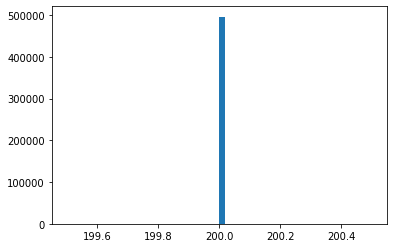

In [44]:
import matplotlib.pyplot as plt
review_lengths = []
for _,review_text in trainsample:
    #review_text=review_text.split()
    review_lengths.append(len(review_text))

plt.hist(review_lengths, bins=50)
plt.show()

In [37]:
num_class = len(set([label for (label, text) in train_validated]))
print(num_class)

2


In [46]:
# -*- coding: utf-8 -*-
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F



class TextCNN(nn.Module):

    def __init__(self,vocab_size,embed_dim):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_dim)
        #self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix))
        self.conv3 = nn.Conv2d(1, 1, (3, 100))
        self.conv4 = nn.Conv2d(1, 1, (4, 100))
        self.conv5 = nn.Conv2d(1, 1, (5, 100))
        self.Max3_pool = nn.MaxPool2d((200-3+1, 1))
        self.Max4_pool = nn.MaxPool2d((200-4+1, 1))
        self.Max5_pool = nn.MaxPool2d((200-5+1, 1))
        self.linear1 = nn.Linear(3, 2)

    def forward(self, x,offsets):
        #print('before',x.shape)
        #batch = x.shape[0]
        embedded = self.embedding(x)
        embedded=embedded.reshape(-1,1,200,100)
        #print('after',embedded.shape)
        # Convolution
        x1 = F.relu(self.conv3(embedded))
        x2 = F.relu(self.conv4(embedded))
        x3 = F.relu(self.conv5(embedded))

        # Pooling
        x1 = self.Max3_pool(x1)
        x2 = self.Max4_pool(x2)
        x3 = self.Max5_pool(x3)

        # capture and concatenate the features
        x = torch.cat((x1, x2, x3), -1) 
        x = x.view(-1, 1, 3)
        #print(x.shape)
        # project the features to the labels
        x = self.linear1(x)
        x = x.view(-1, 2)

        return x



In [47]:
vocab_size = len(vocab)
#emsize = 100
BATCH_SIZE = 250
model = TextCNN(len(vocab), 100).to(device)
# model.embedding.weight=torch.nn.Parameter(torch.from_numpy(weights_matrix))
model.double() #conver value to double

TextCNN(
  (embedding): Embedding(164494, 100)
  (conv3): Conv2d(1, 1, kernel_size=(3, 100), stride=(1, 1))
  (conv4): Conv2d(1, 1, kernel_size=(4, 100), stride=(1, 1))
  (conv5): Conv2d(1, 1, kernel_size=(5, 100), stride=(1, 1))
  (Max3_pool): MaxPool2d(kernel_size=(198, 1), stride=(198, 1), padding=0, dilation=1, ceil_mode=False)
  (Max4_pool): MaxPool2d(kernel_size=(197, 1), stride=(197, 1), padding=0, dilation=1, ceil_mode=False)
  (Max5_pool): MaxPool2d(kernel_size=(196, 1), stride=(196, 1), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3, out_features=2, bias=True)
)

In [49]:

import time
from tqdm import tqdm
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(tqdm(dataloader)):#iterate through all dataloader base on batch size
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label) #calc cross entropy loss
        loss.backward() #backward propgation, modify embedding, fc, 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step() #update everything
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)# calc accuracy
        if idx % log_interval == 0 and idx > 0:#print accuracy
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            print('train loss',loss)
            total_acc, total_count = 0, 0
            start_time = time.time()
    return total_acc/total_count,loss

def evaluate(dataloader):
    model.eval()#set eval mode, will not change weight embedding
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count,loss

In [50]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 500 # batch size for training
#set up models
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = to_map_style_dataset(trainsample)
test_dataset = to_map_style_dataset(testsample)
num_train = int(len(train_dataset) * 0.95)# train95%, and validate 5%, validation to prevent overfit
split_train_, split_valid_ =  random_split(train_dataset, [num_train, len(train_dataset) - num_train])

#load data, randomize all the epoch
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

In [58]:
valAcc=[]
trainAcc=[]
valLoss=[]
trainLoss=[]

for epoch in range(1, EPOCHS + 1):
    #print(epoch,epoch.dtype)
    
    epoch_start_time = time.time()
    accu_train,loss_train=train(train_dataloader)
    accu_val,loss_val = evaluate(valid_dataloader)
    valAcc.append(accu_val)
    trainAcc.append(accu_train)
    valLoss.append(loss_val)
    trainLoss.append(loss_train)
    #if total_accu is not None and total_accu - accu_val>0.1:
      #scheduler.step()
    #else:
       #total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    torch.save(model, 'drive/MyDrive/Colab Notebooks/textcnn'+str(epoch)+'.pkl')
    print('-' * 59)

 53%|█████▎    | 501/943 [19:29<17:13,  2.34s/it]

| epoch   1 |   500/  943 batches | train accuracy    0.818
train loss tensor(0.3920, dtype=torch.float64, grad_fn=<NllLossBackward>)


100%|██████████| 943/943 [36:37<00:00,  2.33s/it]


-----------------------------------------------------------
| end of epoch   1 | time: 2238.52s | valid accuracy    0.817 
-----------------------------------------------------------


 53%|█████▎    | 501/943 [19:27<17:07,  2.33s/it]

| epoch   2 |   500/  943 batches | train accuracy    0.818
train loss tensor(0.4187, dtype=torch.float64, grad_fn=<NllLossBackward>)


100%|██████████| 943/943 [36:34<00:00,  2.33s/it]


-----------------------------------------------------------
| end of epoch   2 | time: 2235.96s | valid accuracy    0.817 
-----------------------------------------------------------


 37%|███▋      | 345/943 [13:27<23:19,  2.34s/it]


KeyboardInterrupt: ignored

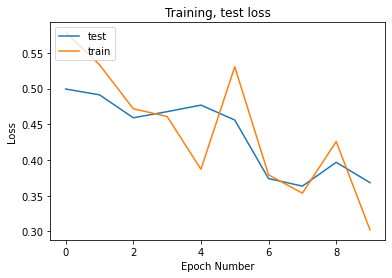

In [52]:
import matplotlib.pyplot as plt
plt.title('Training, test loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(valLoss,label='test')
plt.plot(trainLoss,label='train')
#plt.plot(Val_loss,label='validation')
plt.plot()
plt.legend(loc='upper left')

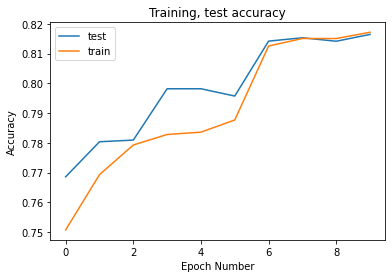

In [53]:
plt.title('Training, test accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(valAcc,label='test')
plt.plot(trainAcc,label='train')
#plt.plot(Val_loss,label='validation')
plt.plot()
plt.legend(loc='upper left')

In [55]:
# not as good as before, as this does not suit pretrained embedding
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print(accu_test)

Checking the results of test dataset.
(0.8060526315789474, tensor(0.4760, dtype=torch.float64))
